The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_6447/2656308713.py:234: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


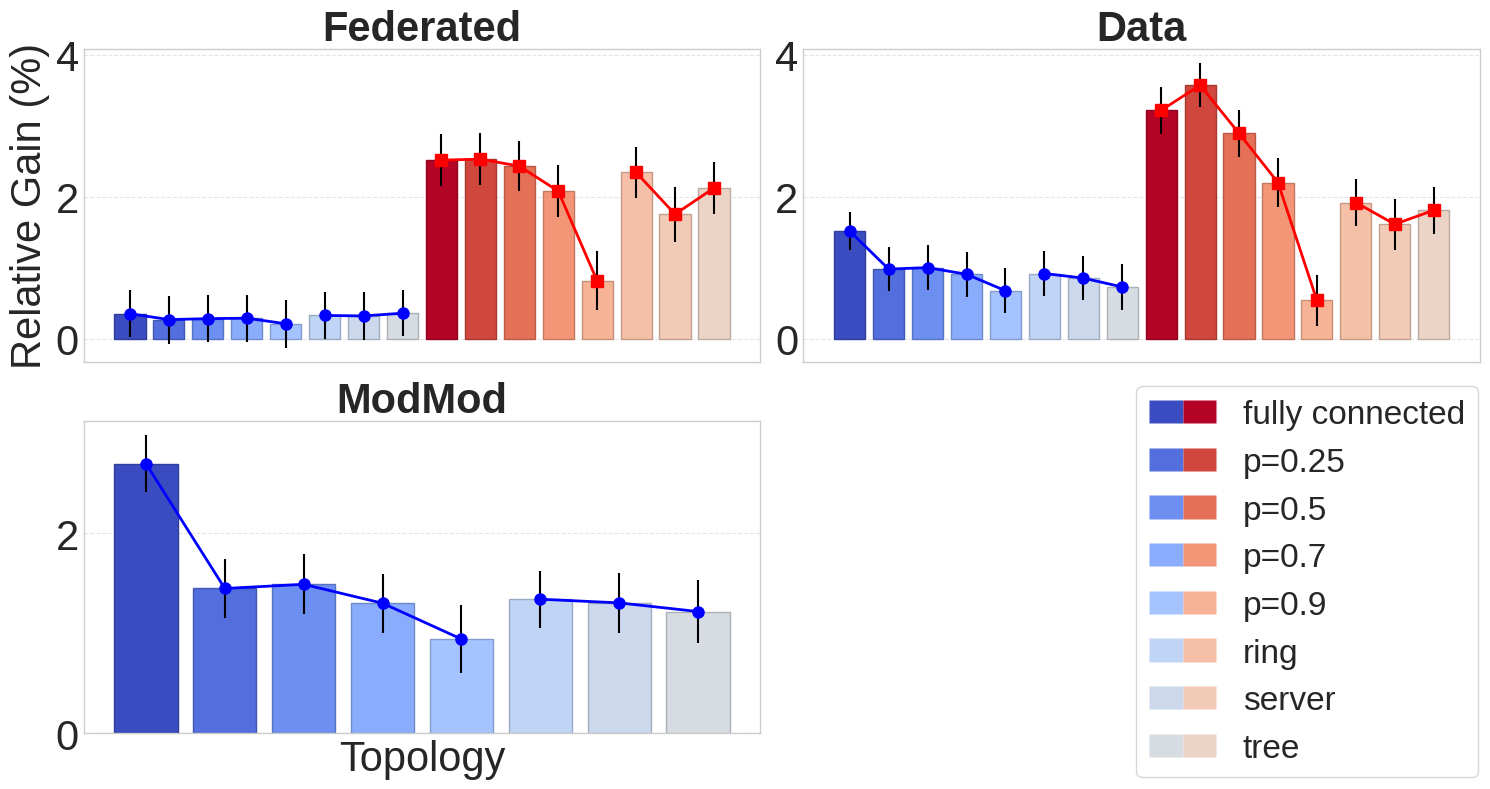

In [18]:
# %%

%load_ext autoreload
%autoreload 2

# %%
from analyze_budget import analyze_multiple
import pandas as pd

# %%
metric = 'auc'
metric = 'final_acc'
error_type = 'sem'

multicolor = True
multi_dataset = False

# %%
def cal_mean_and_error(df, keys=None, metric=None, error_type="sem"):
    if keys is None:
        keys = ["algo", "use_contrastive"]
    if metric is None:
        metric = "final_acc"
    keys += ["dataset"]
    m = df.groupby(keys)[metric].mean()
    if error_type == "sem":
        stderr = df.groupby(keys)[metric].sem()
    else:
        stderr = df.groupby(keys)[metric].std()
    df = pd.DataFrame(m).reset_index()
    df[metric + "_error"] = stderr.values
    return df

def normalize_by_baseline(df):
    df_normalized = df.copy()
    baseline = df_normalized[df_normalized['algo'].str.contains('baseline')].set_index(['dataset', 'algo'])
    baseline_auc = baseline[metric]
    baseline_error = baseline[metric + '_error']

    def normalize_row(row):
        baseline_key = (row['dataset'], 'modular (baseline)' if 'modular' in row['algo'] else 'monolithic (baseline)')
        norm_value = (row[metric] - baseline_auc[baseline_key]) / baseline_auc[baseline_key]
        norm_error = row[metric + '_error'] / baseline_auc[baseline_key]

        return pd.Series([norm_value, norm_error], index=[metric, metric + '_error'])

    df_normalized[[metric, metric + '_error']] = df_normalized.apply(normalize_row, axis=1)
    return df_normalized

def map_datasets_to_new_groups(df):
    dataset_group_map = {
        'mnist': 'avg', 'fashionmnist': 'avg', 'kmnist': 'avg',
        'cifar100': 'avg', 'combined': 'avg'
    }
    df['dataset'] = df['dataset'].map(dataset_group_map)
    return df

def aggregate_by_new_groups(df):
    group_cols = ['dataset', 'use_contrastive', 'algo', 'topology', 'edge_drop']
    return df.groupby(group_cols).mean().reset_index()

def process_topology_df(df, error_type='std'):
    regex = r'^(?P<algo>modular|monolithic)_topology_(?P<topology>[a-zA-Z_]+)_edge_drop_(?P<edge_drop>\d+\.\d+)$'
    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, metric=metric, error_type=error_type)
    df[['algo', 'topology', 'edge_drop']] = df['algo'].str.extract(regex)
    df['algo'] = df['algo'] + '_' + df['topology'] + '_' + df['edge_drop']
    return df

def process_vanilla_df(df, error_type='std'):
    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, metric=metric, error_type=error_type)
    df['algo'] = df['algo'].apply(lambda x: x + ' (baseline)')
    df['edge_drop'] = 0.0
    df['topology'] = 'fully_connected'
    return df

def process_fc_df(df, error_type='std'):
    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, metric=metric, error_type=error_type)
    df['edge_drop'] = "0.0"
    df['topology'] = 'fully_connected'
    df['algo'] = df['algo'] + '_' + df['topology'] + '_' + df['edge_drop']
    return df

def get_fed_df():
    fedavg_path = 'new_topology_experiment_results/jorge_setting_fedavg/comm_freq_5'
    fc_fed_path = "experiment_results/jorge_setting_fedavg"

    fc_fed_df = pd.read_csv(fc_fed_path + '.csv')
    fc_fed_df = process_fc_df(fc_fed_df, error_type=error_type)
    fc_fed_df = fc_fed_df[~(fc_fed_df['dataset'].isin(['combined', 'cifar100']) & fc_fed_df['algo'].str.contains('modular_'))] 

    fed_df = pd.read_csv(fedavg_path + '.csv')
    fed_df = process_topology_df(fed_df, error_type=error_type)
    fed_df = fed_df[fed_df['topology'] != 'random']

    fed_df = fed_df[~(fed_df['dataset'].isin(['combined', 'cifar100']) & fed_df['algo'].str.contains('modular_'))]

    fedprox_path = 'topology_fedprox_results'
    fedprox_df = pd.read_csv(fedprox_path+ '.csv')
    fedprox_df = process_topology_df(fedprox_df, error_type=error_type)
    fedprox_df = fedprox_df[fedprox_df['topology'] != 'random']

    fc_fedprox_path = 'best_fl_results/fedprox_mu_0.001_comm_freq_5'
    fc_fedprox_df = pd.read_csv(fc_fedprox_path + '.csv')
    fc_fedprox_df = process_fc_df(fc_fedprox_df, error_type=error_type)

    vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
    vanilla_df = process_vanilla_df(vanilla_df, error_type=error_type)

    df = pd.concat([fed_df, vanilla_df, fc_fedprox_df, fedprox_df])
    return df

def get_data_df():
    df = pd.read_csv('new_topology_experiment_results/data.csv')
    df = process_topology_df(df, error_type=error_type)
    df = df[df['topology'] != 'random']

    fc_df = pd.read_csv('experiment_results/jorge_setting_recv.csv')
    fc_df = process_fc_df(fc_df, error_type=error_type)

    vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
    vanilla_df = process_vanilla_df(vanilla_df, error_type=error_type)

    vanilla_df = vanilla_df[~((vanilla_df['algo'] == 'monolithic (baseline)') & (vanilla_df['dataset'] == 'cifar100'))]
    df.loc[(df['algo'] == 'monolithic_random_disconnect_1.0') & (df['dataset'] == 'cifar100'), 'algo'] = 'monolithic (baseline)'
    df = pd.concat([df, vanilla_df, fc_df])
    return df

def get_modmod_df():
    modmod_path = 'new_topology_experiment_results/modmod'
    fc_modmod_path = "experiment_results/jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True"
    fc_leep = "/home/vlongle/code/learning-hive/experiment_results/leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True"

    modmod_df = pd.read_csv(modmod_path+ '.csv')
    modmod_df = process_topology_df(modmod_df, error_type=error_type)
    modmod_df = modmod_df[modmod_df['topology'] != 'random']

    fc_df = pd.read_csv(fc_modmod_path + '.csv')
    fc_df = process_fc_df(fc_df, error_type=error_type)

    leep = pd.read_csv(fc_leep + '.csv')
    leep = leep[leep['dataset'] == 'combined']
    leep = process_fc_df(leep, error_type=error_type)

    vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
    vanilla_df = process_vanilla_df(vanilla_df, error_type=error_type)
    
    df = pd.concat([modmod_df, vanilla_df, fc_df, leep])
    return df

# %%
def get_all_dfs():
    fed_df = get_fed_df()
    data_df = get_data_df()
    modmod_df = get_modmod_df()
    return fed_df, data_df, modmod_df

# %%
fed_df, data_df, modmod_df = get_all_dfs()

# %%
fed_df_norm = normalize_by_baseline(fed_df)
data_df_norm = normalize_by_baseline(data_df)
modmod_df_norm = normalize_by_baseline(modmod_df)

fed_df_mapped = map_datasets_to_new_groups(fed_df_norm.copy())
data_df_mapped = map_datasets_to_new_groups(data_df_norm.copy())
modmod_df_mapped = map_datasets_to_new_groups(modmod_df_norm.copy())

# %%
remap_name = {
    'modular_fully_connected_0.0': 'fully connected',
    'modular_random_disconnect_0.25': 'p=0.25',
    'modular_random_disconnect_0.5': 'p=0.5',
    'modular_random_disconnect_0.7': 'p=0.7',
    'modular_random_disconnect_0.9': 'p=0.9',
    'modular_ring_0.0': 'ring',
'modular_server_0.0': 'server',
    'modular_tree_0.0': 'tree',
    'monolithic_fully_connected_0.0': 'fully connected',
    'monolithic_random_disconnect_0.25': 'p=0.25',
    'monolithic_random_disconnect_0.5': 'p=0.5',
    'monolithic_random_disconnect_0.7': 'p=0.7',
    'monolithic_random_disconnect_0.9': 'p=0.9',
    'monolithic_ring_0.0': 'ring',
    'monolithic_server_0.0': 'server',
    'monolithic_tree_0.0': 'tree'
}
import matplotlib.pyplot as plt

# Create a color map using the CoolWarm palette
coolwarm = plt.get_cmap('coolwarm')

color_map = {
    'modular_fully_connected_0.0': coolwarm(0.0),  # Deepest blue
    'modular_random_disconnect_0.25': coolwarm(0.08),
    'modular_random_disconnect_0.5': coolwarm(0.16),
    'modular_random_disconnect_0.7': coolwarm(0.24),
    'modular_random_disconnect_0.9': coolwarm(0.32),
    'modular_ring_0.0': coolwarm(0.40),
    'modular_server_0.0': coolwarm(0.44),
    'modular_tree_0.0': coolwarm(0.48),
}

# Monolithic configurations in reds, with a consistent descending pattern
color_map.update({
    'monolithic_fully_connected_0.0': coolwarm(1.0),  # Deepest red
    'monolithic_random_disconnect_0.25': coolwarm(0.92),
    'monolithic_random_disconnect_0.5': coolwarm(0.84),
    'monolithic_random_disconnect_0.7': coolwarm(0.76),
    'monolithic_random_disconnect_0.9': coolwarm(0.68),
    'monolithic_ring_0.0': coolwarm(0.64),
    'monolithic_server_0.0': coolwarm(0.60),
    'monolithic_tree_0.0': coolwarm(0.56),
})

# Define darker variants for edge colors for better contrast
edgecolor_map = {}
for key, color in color_map.items():
    # Extract RGB values and darken them by reducing brightness
    r, g, b, a = color
    factor = 0.8  # Darken by 20%
    darker_color = (r * factor, g * factor, b * factor, a)
    edgecolor_map[key] = darker_color

# %%
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.collections import PatchCollection

plt.style.use('seaborn-whitegrid')

class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors

class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches, match_original=True)

        handlebox.add_artist(patch)
        return patch
def plot(df, color_map, edgecolor_map, remap_name, name='', ax=None, include_legend=True, multicolor=True, include_ylabel=True, include_xlabel=True):
    if ax is None:
        figsize = (15, 5)
        fig, ax = plt.subplots(figsize=figsize)

    legend_entries = {}
    df = df[df['algo'].isin(remap_name.keys())]
    for i, (algo, v, v_err) in enumerate(zip(df['algo'], df[metric], df[metric + '_error'])):
        bar = ax.bar(i, v, color=color_map[algo], label=remap_name[algo],
                    edgecolor=edgecolor_map[algo], yerr=v_err, width=0.8)
        label = remap_name[algo]
        if label not in legend_entries:
            legend_entries[label] = [None, None]
        if 'modular' in algo:
            legend_entries[label][0] = color_map[algo]
        elif 'monolithic' in algo:
            legend_entries[label][1] = color_map[algo]

    metric_label = {
        'auc': 'AUC',
        'final_acc': 'Final accuracy'
    }
    metric_l = metric_label[metric]
    ax.set_xticks([])
    if include_ylabel:
        ax.set_ylabel('Relative Gain (%)', fontsize=30)
    if include_xlabel:
        ax.set_xlabel('Topology', fontsize=30)
    ax.tick_params(axis='y', labelsize=30)

    if include_legend:
        if multicolor:
            ax.legend([MulticolorPatch(c) for c in legend_entries.values()], legend_entries.keys(),
                      handler_map={MulticolorPatch: MulticolorPatchHandler()}, frameon=True, loc='lower right',
                      bbox_to_anchor=(1.1, 0.0), fontsize=30)
        else:
            ax.legend(frameon=True, loc='lower right', bbox_to_anchor=(1.1, 0.0), fontsize=30)

    ax.grid(True, which='major', linestyle='--', alpha=0.5)
    
    # Add lines to show the trend for modular and monolithic
    modular_values = df[df['algo'].str.contains('modular')][metric].values
    monolithic_values = df[df['algo'].str.contains('monolithic')][metric].values

    # Plot lines for modular and monolithic with gaps
    modular_indices = [i for i, algo in enumerate(df['algo']) if 'modular' in algo]
    monolithic_indices = [i for i, algo in enumerate(df['algo']) if 'monolithic' in algo]
    
    # Define styles for lines
    modular_line_style = dict(color='blue', linestyle='-', linewidth=2, marker='o', markersize=8,)
    monolithic_line_style = dict(color='red', linestyle='-', linewidth=2, marker='s', markersize=8)

    # Plot lines for modular with gaps
    p_indices_modular = [i for i in modular_indices if df['algo'].iloc[i] not in ['modular_ring_0.0', 'modular_server_0.0', 'modular_tree_0.0']]
    topology_indices_modular = [i for i in modular_indices if df['algo'].iloc[i] in ['modular_ring_0.0', 'modular_server_0.0', 'modular_tree_0.0']]
    
    ax.plot(p_indices_modular, modular_values[:len(p_indices_modular)], **modular_line_style)
    ax.plot(topology_indices_modular, modular_values[len(p_indices_modular):], **modular_line_style)
    
    # Plot lines for monolithic with gaps
    p_indices_monolithic = [i for i in monolithic_indices if df['algo'].iloc[i] not in ['monolithic_ring_0.0', 'monolithic_server_0.0', 'monolithic_tree_0.0']]
    topology_indices_monolithic = [i for i in monolithic_indices if df['algo'].iloc[i] in ['monolithic_ring_0.0', 'monolithic_server_0.0', 'monolithic_tree_0.0']]
    
    ax.plot(p_indices_monolithic, monolithic_values[:len(p_indices_monolithic)], **monolithic_line_style)
    ax.plot(topology_indices_monolithic, monolithic_values[len(p_indices_monolithic):], **monolithic_line_style)

    return legend_entries


# %%
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

fed_df_mapped = aggregate_by_new_groups(fed_df_mapped)
data_df_mapped = aggregate_by_new_groups(data_df_mapped)
modmod_df_mapped = aggregate_by_new_groups(modmod_df_mapped)

fed_df_mapped[metric] *= 100
fed_df_mapped[metric + '_error'] *= 100
data_df_mapped[metric] *= 100
data_df_mapped[metric + '_error'] *= 100
modmod_df_mapped[metric] *= 100
modmod_df_mapped[metric + '_error'] *= 100

# fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharey=True,)
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[0, 0:2])

legend_entries_fed = plot(fed_df_mapped, color_map, edgecolor_map, remap_name, name='Federated', ax=ax1, multicolor=multicolor, include_xlabel=False, include_legend=False)
ax1.set_title('Federated', fontsize=30, weight='bold')

ax2 = fig.add_subplot(gs[0, 2:4], sharey=ax1)
plot(data_df_mapped, color_map, edgecolor_map, remap_name, name='Data', ax=ax2, multicolor=multicolor, include_legend=False, include_ylabel=False, include_xlabel=False)
ax2.set_title('Data', fontsize=30, weight='bold')

ax3 = fig.add_subplot(gs[1, 0:2])
plot(modmod_df_mapped, color_map, edgecolor_map, remap_name, name='ModMod', ax=ax3, multicolor=multicolor, include_legend=False, include_ylabel=False)
ax3.set_title('ModMod', fontsize=30, weight='bold')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

combined_legend_entries = {**legend_entries_fed}

# Create a new legend
handles = [MulticolorPatch(c) for c in combined_legend_entries.values()]
labels = combined_legend_entries.keys()

fig.legend(handles, labels, handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc='lower right', fontsize=24, ncol=1, frameon=True, bbox_to_anchor=(1.0, 0.0))

fig.tight_layout()
fig.savefig('Figures/combined_topology.pdf')
